# IQ modulation for Chirp

http://zone.ni.com/reference/en-XX/help/372058T-01/nirfsa/iq_modulation/

## IQ modulation

http://zone.ni.com/reference/en-XX/help/372058T-01/nirfsa/iq_modulation/

### Modulation

$$ I(t) = R(t) \cos(\omega_b t) $$

$$ Q(t) = R(t) \sin(\omega_b t) $$

$$ p(t) = I(t) \cos(\omega_c t) + Q(t) \sin(\omega_c t) = R(t) \cos(\omega_c t - \omega_b t)$$

In case of Chirp, R(t) is constant (Amplitude):

$$ k = \frac{f_1-f_0}{T} $$

$$ \omega_b(t) = 2\pi \left(f_0 + \frac{k}{2} t \right) $$

$$ I(t) = A \cos(\omega_b(t) t) $$

$$ Q(t) = A \sin(\omega_b(t) t) $$

$$ p(t) = I(t) \cos(\omega_c t) - Q(t) \sin(\omega_c t) = A \cos(\omega_c t + \omega_b(t) t)$$

### Demodulation

After low-pass filter,

$$ I(t) = p(t) \cos(\omega_c t)  $$

$$ Q(t) = p(t) \sin(\omega_c t)  $$

In [31]:
%matplotlib inline
% run ./chirp.py

In [32]:
# Chirp bandwidth in Hz
BW = 2000

# Carrier in Hz
CARRIER=18000

In [33]:
F0 = -BW/2
F1 = +BW/2

In [34]:
def carrier_IQ(iq, f=CARRIER, T=TIME_FRAME):
    t = linspace(0, T, int(T * Fs))
    if iq == 'I':
        return cos(2 * pi * f * t)
    elif iq == 'Q':
        return sin(2 * pi * f * t)
    
def chirp_x_carrier(f0=F0, f1=F1, T=TIME_FRAME, updown="up"):
    t = linspace(0, T, int(T * Fs))
    k = float(f1-f0)/float(T)
    if (updown == "up"):
        f = f0 + k * t / 2.0
    elif (updown == "down"):
        f = f1 - k * t / 2.0
    arg = 2 * pi * (CARRIER - f) * t
    return cos(arg) * AMPLITUDE

## Carrier

In [35]:
Ci = carrier_IQ('I')
Cq = carrier_IQ('Q')

Frequencies at peaks: [-18000.  18000.] Hz


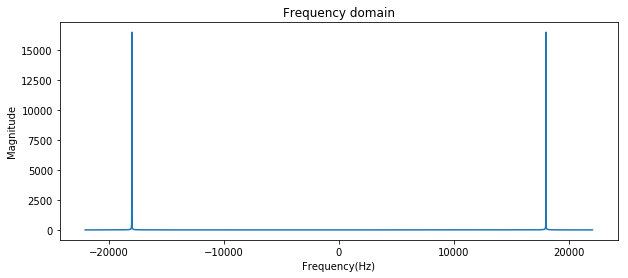

In [36]:
plot_fft(Ci)

Frequencies at peaks: [-18000.  18000.] Hz


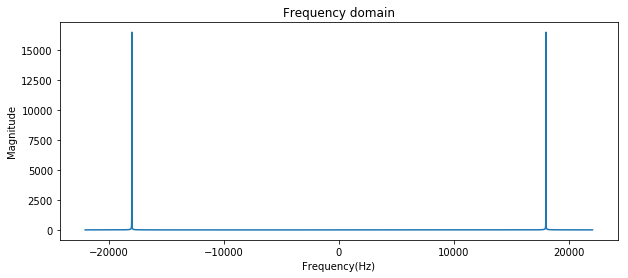

In [37]:
plot_fft(Cq)

## Baseband signal

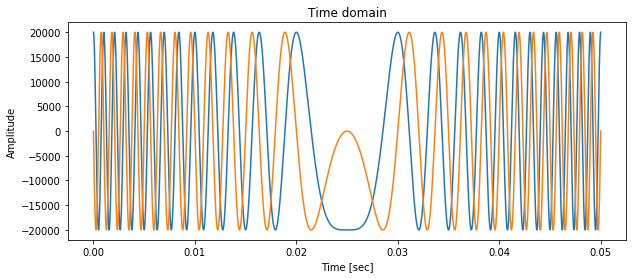

In [38]:
# Up chipr
plot_wave(chirp(f0=F0, f1=F1, T=0.05, phase=0), real_only=False)

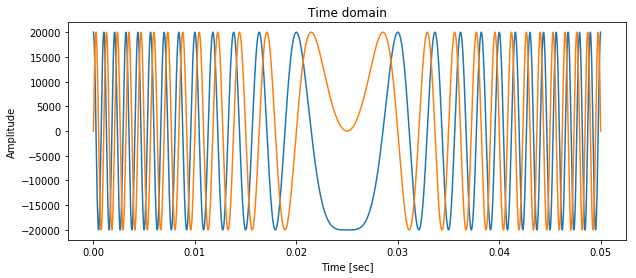

In [39]:
# Down chirp
plot_wave(chirp(f0=F0, f1=F1, T=0.05, phase=0).conjugate(), real_only=False)

## I/Q modulation 

In [40]:
WW = chirp_x_carrier(f0=F0, f1=F1, T=0.05)
WWd = chirp_x_carrier(f0=F0, f1=F1, T=0.05, updown="down")

Frequencies at peaks: [-18840. -17180.  17180.  18840.] Hz


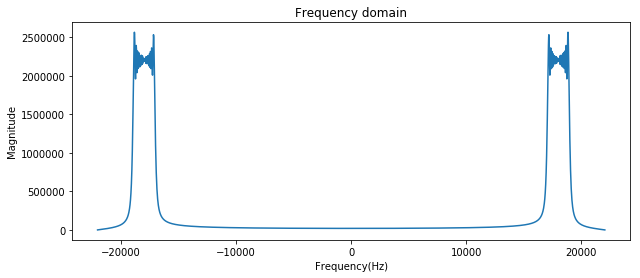

In [41]:
plot_fft(WW)

## I/Q demodulation

In [42]:
Ri = WW*carrier_IQ('I', T=0.05)
Rq = WW*carrier_IQ('Q', T=0.05)
Rid = WWd*carrier_IQ('I', T=0.05)
Rqd = WWd*carrier_IQ('Q', T=0.05)

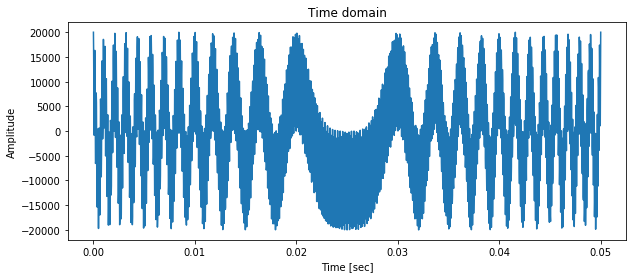

In [43]:
plot_wave(Ri)

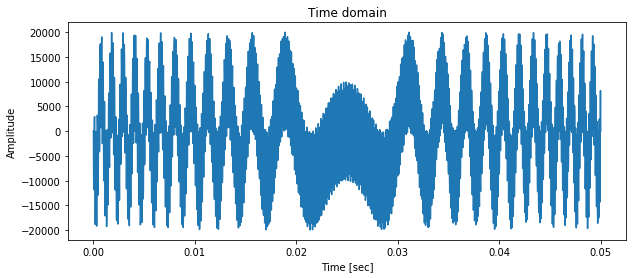

In [44]:
plot_wave(Rq)

Frequencies at peaks: [-780. -700. -640. -540. -500. -460. -360. -300. -220. -100.  100.  220.
  300.  360.  460.  500.  540.  640.  700.  780.] Hz


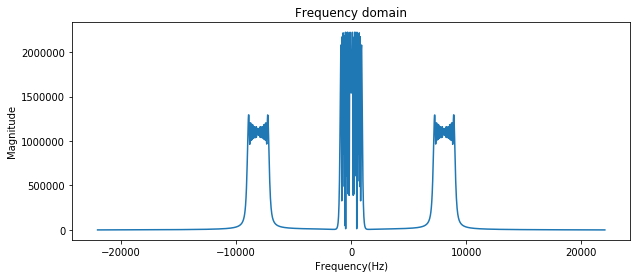

In [45]:
plot_fft(Ri)

Frequencies at peaks: [-820.  820.] Hz


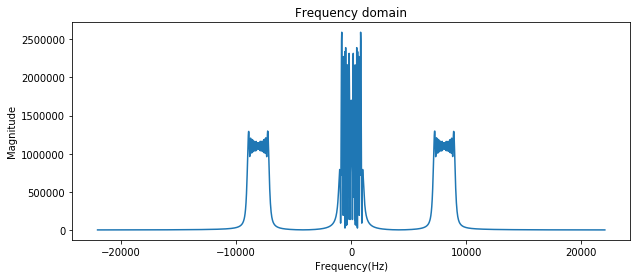

In [46]:
plot_fft(Rq)

## Low-pass filter to remove 2 * carrier frequency terms

In [47]:
# LPF
CUTOFF = 3000
R = lpf(Ri, CUTOFF) + 1j*lpf(Rq, CUTOFF)
Rd = lpf(Rid, CUTOFF) + 1j*lpf(Rqd, CUTOFF)

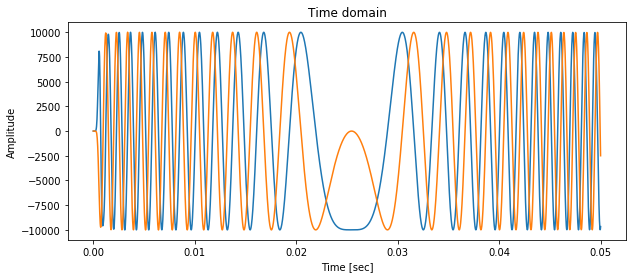

In [48]:
plot_wave(R, real_only=False)

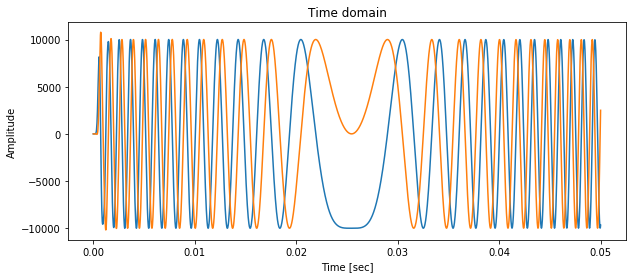

In [49]:
plot_wave(Rd, real_only=False)

Frequencies at peaks: [-840.  820.] Hz


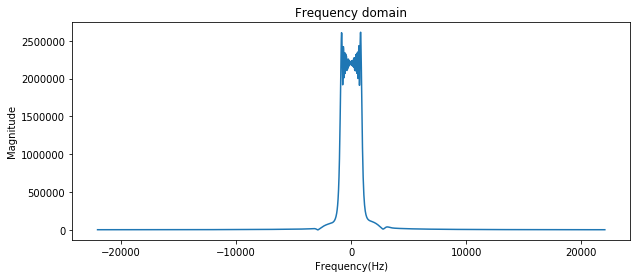

In [50]:
plot_fft(R)

Frequencies at peaks: [-820.  840.] Hz


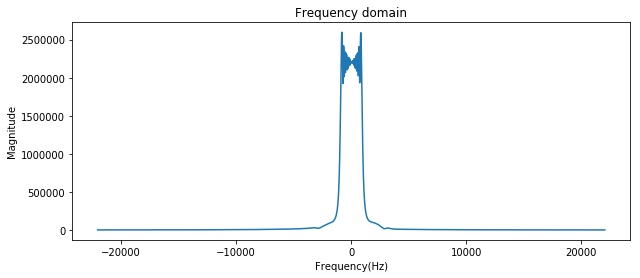

In [51]:
plot_fft(Rd)

## Anlyzing baseband signal

Frequencies at peaks: [-1740.  1740.] Hz


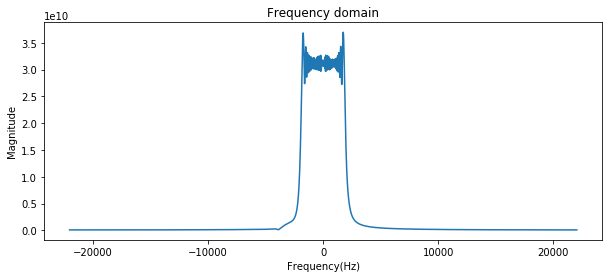

In [52]:
# Up-chirp detection fails
plot_fft(R*chirp(f0=F0, f1=F1, T=0.05), logscale=False)

Frequencies at peaks: [-20.] Hz


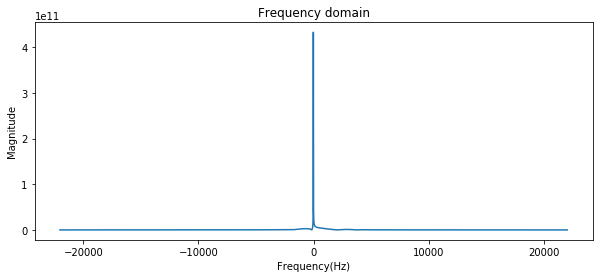

In [53]:
# Up-chirp detection suceeds
plot_fft(R*chirp(f0=F0, f1=F1, T=0.05).conjugate(), logscale=False)

Frequencies at peaks: [20.] Hz


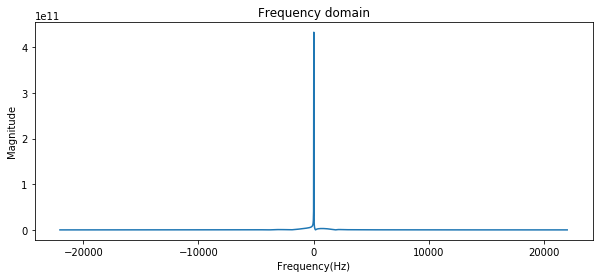

In [54]:
# Down-chirp detection suceeds
plot_fft(Rd*chirp(f0=F0, f1=F1, T=0.05), logscale=False)

Frequencies at peaks: [-1740.  1740.] Hz


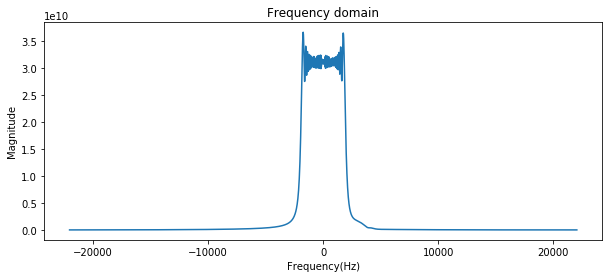

In [55]:
# Down-chirp detection fails
plot_fft(Rd*chirp(f0=F0, f1=F1, T=0.05).conjugate(), logscale=False)